In [40]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import os
import json

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
on_pc = os.path.isdir('data')
if on_pc: 
    data_directory = "data/"
else:
    data_directory = "/kaggle/input/hubmap-hacking-the-human-vasculature/"

# Goals of the Competition
Goal of the Competition
The goal of this competition is to segment instances of microvascular structures, including capillaries, arterioles, and venules. You'll create a model trained on 2D PAS-stained histology images from healthy human kidney tissue slides.

Your help in automating the segmentation of microvasculature structures will improve researchers' understanding of how the blood vessels are arranged in human tissues

# Dataset description
Your goal in this competition is to locate microvasculature structures (blood vessels) within human kidney histology slides.

The competition data comprises tiles extracted from five Whole Slide Images (WSI) split into two datasets. Tiles from Dataset 1 have annotations that have been expert reviewed. Dataset 2 comprises the remaining tiles from these same WSIs and contain sparse annotations that have not been expert reviewed.

- All of the test set tiles are from Dataset 1.
- Two of the WSIs make up the training set, two WSIs make up the public test set, and one WSI makes up the private test set.
- The training data includes Dataset 2 tiles from the public test WSI, but not from the private test WSI.

We also include, as Dataset 3, tiles extracted from an additional nine WSIs. These tiles have not been annotated. You may wish to apply semi- or self-supervised learning techniques on this data to support your predictions.

Note that this is a Code Competition, in which the actual test set is hidden. In this version, we give some sample data drawn from the public test set to help you author your solutions. When your submission is scored, this example test data will be replaced with the full test set. There are about 650 tiles in the full test set.

You may find resources from the previous HuBMAP competitions useful as well:

- HuBMAP: Hacking the Kidney (https://www.kaggle.com/competitions/hubmap-kidney-segmentation/)
- HuBMAP + HPA: Hacking the Human Body (https://www.kaggle.com/competitions/hubmap-organ-segmentation/)

## Files and Field Descriptions
**{train|test}/ Folders** - containing TIFF images of the tiles. Each tile is 512x512 in size.

In [4]:
import glob

def number_tif_files(directory):
    file_pattern = f'{directory}*.tif'
    tif_files = glob.glob(file_pattern)
    print(f'Number .tif files in {directory}: {len(tif_files)}')

number_tif_files(f'{data_directory}train/')
number_tif_files(f'{data_directory}test/')

Number .tif files in data/train/: 7033
Number .tif files in data/test/: 1


**sample_submission.csv** - A sample submission file in the correct format. See the Evaluation page (https://www.kaggle.com/competitions/hubmap-hacking-the-human-vasculature/overview/evaluation) for more details:
- bitová maska stejné velikosti jako obrázek (512 x 512), která je převedena na **prediction_string**
- **prediction_string** has the format 0 {confidence} {EncodedMask}
- Segmentation is calculated using IoU (Intersection over Union) with a threshold of 0.6

In [5]:
pd.read_csv("data/sample_submission.csv")

,id,height,width,prediction_string
0,72e40acccadf,512,512,0 1.0 eNoLTDAwyrM3yI/PMwcAE94DZA==


**polygons.jsonl** - Polygonal segmentation masks in JSONL format, available for Dataset 1 and Dataset 2. Each line gives JSON annotations for a single image with:
- id Identifies the corresponding image in train/
- annotations A list of mask annotations with:
- type Identifies the type of structure annotated:
    - blood_vessel The target structure. Your goal in this competition is to predict these kinds of masks on the test set.
    - glomerulus A capillary ball structure in the kidney. These parts of the images were excluded from blood vessel annotation. You should ensure none of your test set predictions occur within glomerulus structures as they will be counted as false positives. Annotations are provided for test set tiles in the hidden version of the dataset.
    - unsure A structure the expert annotators cannot confidently distinguish as a blood vessel.
- coordinates A list of polygon coordinates defining the segmentation mask.

In [66]:
#with open(f"{data_directory}polygons.jsonl", "rb") as f:
#    print(json.load(f"{data_directory}polygons.jsonl"))

with open(f"{data_directory}polygons.jsonl",'r') as json_file:
    json_list = list(json_file)

result = {}
for json_str in json_list:
    obj = json.loads(json_str)
    result[obj["id"]] = obj["annotations"]

print(result["0006ff2aa7cd"])


[{'type': 'glomerulus', 'coordinates': [[[167, 249], [166, 249], [165, 249], [164, 249], [163, 249], [162, 249], [161, 249], [160, 249], [159, 249], [158, 249], [157, 249], [156, 249], [155, 249], [154, 249], [153, 249], [152, 249], [151, 249], [150, 249], [149, 249], [148, 249], [147, 249], [146, 249], [145, 249], [144, 249], [143, 249], [142, 249], [141, 249], [140, 249], [139, 249], [138, 249], [137, 249], [136, 249], [135, 249], [134, 249], [133, 249], [132, 249], [131, 249], [130, 249], [129, 249], [128, 249], [127, 249], [126, 249], [125, 249], [124, 249], [123, 249], [122, 249], [122, 248], [121, 248], [120, 248], [119, 248], [118, 248], [117, 248], [117, 247], [116, 247], [115, 247], [115, 246], [114, 246], [113, 246], [112, 246], [111, 246], [110, 246], [110, 245], [109, 245], [108, 245], [107, 245], [106, 245], [106, 244], [105, 244], [105, 243], [104, 243], [103, 243], [103, 242], [102, 242], [101, 242], [100, 242], [99, 242], [99, 241], [98, 241], [98, 240], [97, 240], [97,

In [104]:
def to_bitmap(coordinates):
    coordinates = np.squeeze(coordinates)
    res = np.zeros([512, 512])
    for (x, y) in coordinates:
        res[x, y] = 1
    return res

a = to_bitmap(result["0006ff2aa7cd"][0]["coordinates"])

In [108]:
len(to_bitmap(result["0006ff2aa7cd"]))

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

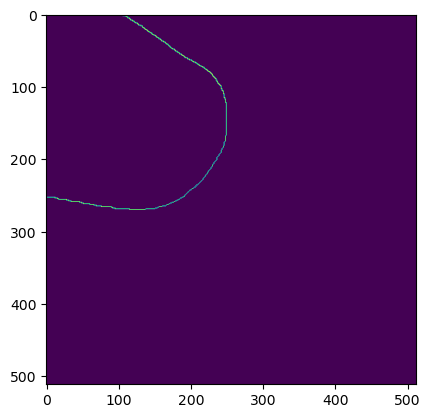

In [15]:
plt.imshow(a)
plt.show()

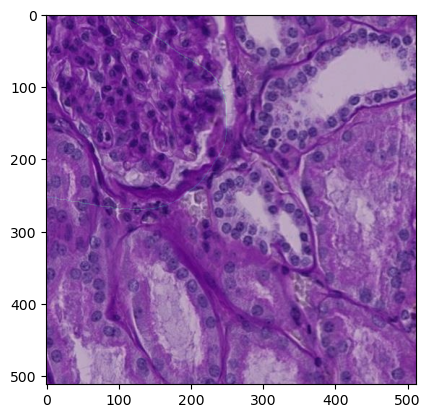

In [34]:
I = plt.imread(f"{data_directory}train/0006ff2aa7cd.tif")
plt.imshow(I)
plt.imshow(a, alpha=0.2)
plt.show()

In [7]:
jsonObj = pd.read_json(path_or_buf=f"{data_directory}polygons.jsonl", lines=True, encoding="UTF-8")
jsonObj

,id,annotations
0,0006ff2aa7cd,"[{'type': 'glomerulus', 'coordinates': [[[167,..."
1,00168d1b7522,"[{'type': 'glomerulus', 'coordinates': [[[511,..."
2,0033bbc76b6b,"[{'type': 'blood_vessel', 'coordinates': [[[16..."
3,003504460b3a,"[{'type': 'blood_vessel', 'coordinates': [[[40..."
4,004daf1cbe75,"[{'type': 'blood_vessel', 'coordinates': [[[14..."
...,...,...
1628,ff434af74304,"[{'type': 'blood_vessel', 'coordinates': [[[29..."
1629,ff4897b3eda6,"[{'type': 'blood_vessel', 'coordinates': [[[29..."
1630,ff66dec71c4c,"[{'type': 'blood_vessel', 'coordinates': [[[11..."
1631,ff99cdef0f2a,"[{'type': 'blood_vessel', 'coordinates': [[[24..."


**tile_meta.csv** - Metadata for each image. The hidden version of this file also contains metadata for the test set tiles.
* source_wsi Identifies the WSI this tile was extracted from.
* {i|j} The location of the upper-left corner within the WSI where the tile was extracted.
* dataset The dataset this tile belongs to, as described above.

In [8]:
pd.read_csv(f"{data_directory}tile_meta.csv")

,id,source_wsi,dataset,i,j
0,0006ff2aa7cd,2,2,16896,16420
1,000e79e206b7,6,3,10240,29184
2,00168d1b7522,2,2,14848,14884
3,00176a88fdb0,7,3,14848,25088
4,0033bbc76b6b,1,1,10240,43008
...,...,...,...,...,...
7028,ffd37b5c6598,13,3,13824,21504
7029,ffd3d193c71e,3,2,7680,16896
7030,ffd77e2517af,13,3,15872,28160
7031,ffe3cbb81f72,10,3,15456,23000


**wsi_meta.csv** - Metadata for the Whole Slide Images the tiles were extracted from.
* source_wsi Identifies the WSI.
* age, sex, race, height, weight, and bmi demographic information about the tissue donor.

In [9]:
pd.read_csv(f"{data_directory}wsi_meta.csv")

,source_wsi,age,sex,race,height,weight,bmi
0,1,58,F,W,160.0,59.0,23.0
1,2,56,F,W,175.2,139.6,45.5
2,3,73,F,W,162.3,87.5,33.2
3,4,53,M,B,166.0,73.0,26.5


# Data analysis

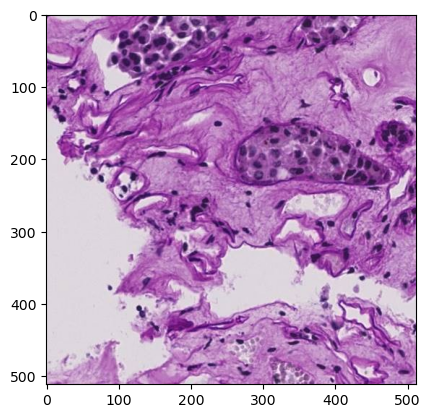

In [10]:
I = plt.imread(f"{data_directory}test/72e40acccadf.tif")
plt.imshow(I)
plt.show()

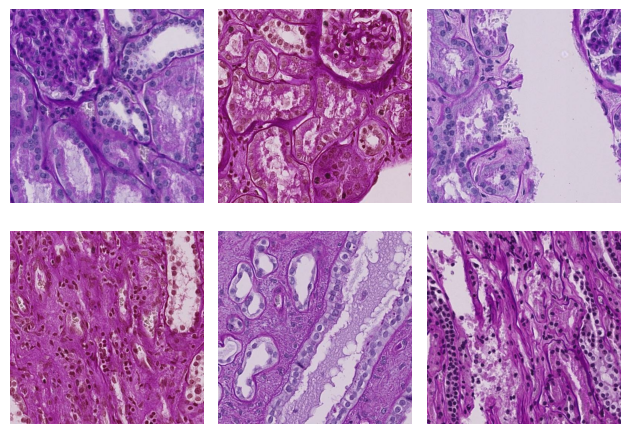

In [11]:
import os
# Directory containing the files
train_directory = f'{data_directory}train'

# Get the first 10 files in the directory
file_list = sorted(os.listdir(train_directory))[:6]

# Create subplots to display multiple images
num_images = len(file_list)
rows = 2
cols = num_images//rows
fig, axes = plt.subplots(rows, cols)

# Iterate over the files and display them
for i, file_name in enumerate(file_list):
    # Get the full file path
    file_path = os.path.join(train_directory, file_name)
    
    # Load the image
    image = plt.imread(file_path)
    
    # Display the image
    axes[i//cols][i%cols].imshow(image)
    axes[i//cols][i%cols].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

## Dataset & Dataloader

In [116]:
import torch
from torch.utils.data import Dataset
from torchvision.io import read_image

from enum import IntEnum

class StructureValue(IntEnum):

    BLOOD_VESSEL = 1 * 100
    GLOMERULUS = 2 * 100
    #BOTH = 3 * 100
    UNSURE = 4 * 100

    
    @staticmethod
    def get_value(type):
        if type == 'blood_vessel':
            return StructureValue.BLOOD_VESSEL
        elif type == 'glomerulus':
            return StructureValue.GLOMERULUS
        else:
            return StructureValue.UNSURE


class TifImageDataset(Dataset):
    def __init__(self, img_dir, annotation_file):
        self.img_dir = img_dir
        self.tif_files = [file for file in os.listdir(img_dir)]

        with open(f"{data_directory}polygons.jsonl",'r') as json_file:
            json_list = list(json_file)

        result = {}
        for json_str in json_list:
            obj = json.loads(json_str)
            result[obj["id"]] = obj["annotations"]
        
        self.annotations = result
        print(type(self.annotations))

    def __len__(self):
        return len(self.tif_files)

    def to_bitmap(coordinates):
        coordinates = np.squeeze(coordinates)
        res = np.zeros([512, 512])
        for (x, y) in coordinates:
            res[x, y] = 1
        return res
    
    def __getitem__(self, idx):
        image_name = self.tif_files[idx]
        #image = read_image(os.path.join(self.img_dir, image_name))
        image = plt.imread(os.path.join(self.img_dir, image_name))
        
        image_annotations = self.annotations[image_name.split('.')[0]]
        mask = np.zeros([512, 512])
        for annotation in image_annotations:
            type_value = StructureValue.get_value(annotation['type'])
            print(type_value)
            for coordinates in annotation['coordinates']:
                for (x, y) in coordinates:
                    current_value = mask[x, y]

                    if current_value == 0:
                        mask[x, y] = type_value
                    else:
                        if type_value == StructureValue.UNSURE:
                            continue

                        if current_value == StructureValue.UNSURE:
                            mask[x, y] = type_value
                        elif type_value != current_value:
                            mask[x, y] = StructureValue.GLOMERULUS

        return image, mask

train_dataset = TifImageDataset(f'{data_directory}train/', f'{data_directory}polygons.jsonl')
mask = train_dataset.__getitem__(0)[1]

all_values = set()
for i in range(512):
    for j in range(512):
        all_values.add(mask[i, j])

print(all_values)

<class 'dict'>
StructureValue.GLOMERULUS
StructureValue.BLOOD_VESSEL
StructureValue.BLOOD_VESSEL
StructureValue.BLOOD_VESSEL
StructureValue.BLOOD_VESSEL
StructureValue.BLOOD_VESSEL
StructureValue.BLOOD_VESSEL
StructureValue.BLOOD_VESSEL
StructureValue.BLOOD_VESSEL
{0.0, 100.0, 200.0}


## Neural network

In [42]:
import torch.nn.functional as F
from torch import nn

In [45]:
I.shape

(512, 512, 3)

In [57]:
a = torch.randn(1, 3, 512, 512)
a.shape

torch.Size([1, 3, 512, 512])

In [118]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.conv3(x)
        return x



with torch.no_grad():
    model = CNN()

    # Create a random input tensor with shape 1x3x512x512
    input_tensor = torch.randn(1, 3, 512, 512)

    # Forward pass through the model
    output_tensor = model(torch.tensor(I.reshape(1,3,512,512)).float())

    # Print the shape of the output tensor
    print(output_tensor.shape)

torch.Size([1, 1, 512, 512])


In [ ]:
def train_one_epoch(model, loss_function, optimizer, training_loader, verbose = True, show_graph = False):
    running_cum_loss = 0
    losses = []
    for i, data in enumerate(training_loader):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = loss_function(outputs, labels)
        
        loss.backward()

        
        optimizer.step() # Adjust learning weights

        #  report
        last_mean_loss = loss.item()
        losses.append(last_mean_loss)
        running_cum_loss += last_mean_loss * inputs.shape[0]
        if verbose == True:
            if i % 300 == 299:
                print(f"  batch {i+1} loss: {last_mean_loss:.3f}")
            
    if show_graph:
        plt.plot(range(1,len(losses)+1),losses, '-')
        plt.show()
    # Return of the average over the whole training set
    return running_cum_loss / len(train_data)